In [1]:
!nvidia-smi

Sun Oct  1 11:44:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P4              26W / 131W |   1494MiB /  6141MiB |     61%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# torch.cuda.amp.autocast(enabled=True)
print(device)

cuda:0


In [3]:
from dataloader import get_loaders
from transforms import train_transforms,test_transforms
from utils import test,train
from models import Net
from viz import (
        plot_class_distribution,
        plot_confusion_matrix,
        plot_data,
        plot_model_training_curves,
        plot_incorrect_preds,
        get_all_and_incorrect_preds
)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [5]:
kwargs = kwargs = {'batch_size':32,'shuffle':True,'num_workers':2,'pin_memory':False,'download':True}
if device.type=='cuda':
    kwargs = {
        'batch_size':256,
        'shuffle':True,
        'num_workers':os.cpu_count(),
        'pin_memory':True,
        'download':True
    }
train_loader, test_loader = get_loaders(
                                train_transforms=train_transforms,
                                test_transforms=test_transforms,
                                num_workers= kwargs['num_workers'],
                                batch_size=kwargs['batch_size'],
                                pin_memory=kwargs['pin_memory'],
                                download=kwargs['download'] 
                            )

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = train_loader.dataset.classes

### Class Distributions

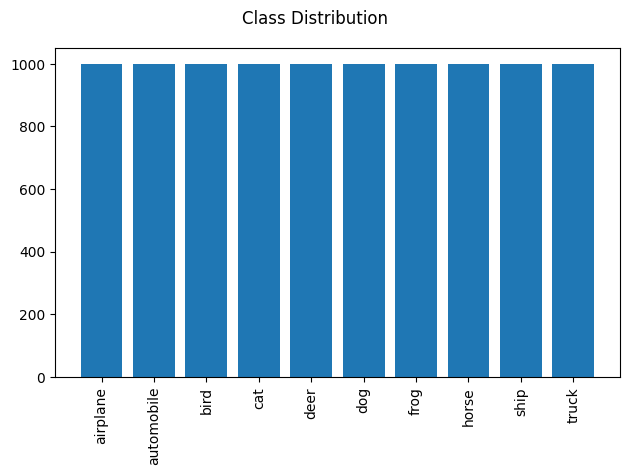

In [7]:
plot_class_distribution(test_loader,classes)

### Plot Examples

C:\Users\muthu\Documents\TSAI\session 8\Ablation\viz.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


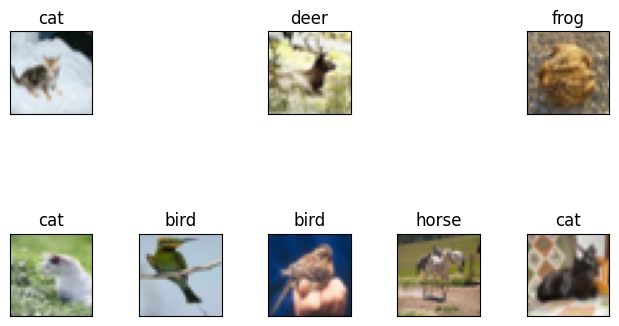

In [8]:
plot_data(loader=test_loader,classes=classes)

# BN

In [9]:
model = Net(
                norm_method='bn',
                # channels = [3,16,20,28,40,10],
                grp=0,
                dp_rate=0.1
        ).to(device)

summary(model,(3,32,32),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
         ConvLayer-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,304
       BatchNorm2d-7           [-1, 16, 32, 32]              32
              ReLU-8           [-1, 16, 32, 32]               0
         Dropout2d-9           [-1, 16, 32, 32]               0
        ConvLayer-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]             256
        MaxPool2d-12           [-1, 16, 16, 16]               0
       TransBlock-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 20,

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=3,factor=0.1)
# New Line
criterion = F.nll_loss
num_epochs = 20

In [11]:
%%time

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(model, device, train_loader, optimizer, criterion)
  test_accs, test_losses = test(model, device, test_loader, criterion)
  scheduler.step(test_losses[-1])

Epoch 1
Train: 100% Loss=1.8931 Batch_id=195 Accuracy=28.52
Test set: Average loss: 1.8645, Accuracy: 3245/10000 (32.45%)

Epoch 2
Train: 100% Loss=1.6195 Batch_id=195 Accuracy=38.60
Test set: Average loss: 2.0908, Accuracy: 3351/10000 (33.51%)

Epoch 3
Train: 100% Loss=1.7237 Batch_id=195 Accuracy=42.52
Test set: Average loss: 2.0787, Accuracy: 3169/10000 (31.69%)

Epoch 4
Train: 100% Loss=1.5571 Batch_id=195 Accuracy=45.74
Test set: Average loss: 1.6423, Accuracy: 4239/10000 (42.39%)

Epoch 5
Train: 100% Loss=1.5868 Batch_id=195 Accuracy=47.73
Test set: Average loss: 2.0754, Accuracy: 3986/10000 (39.86%)

Epoch 6
Train: 100% Loss=1.5808 Batch_id=195 Accuracy=49.48
Test set: Average loss: 1.8750, Accuracy: 4145/10000 (41.45%)

Epoch 7
Train: 100% Loss=1.2929 Batch_id=195 Accuracy=51.24
Test set: Average loss: 1.7504, Accuracy: 4351/10000 (43.51%)

Epoch 8
Train: 100% Loss=1.2717 Batch_id=195 Accuracy=52.06
Test set: Average loss: 1.5216, Accuracy: 4947/10000 (49.47%)

Epoch 9
Train: 1

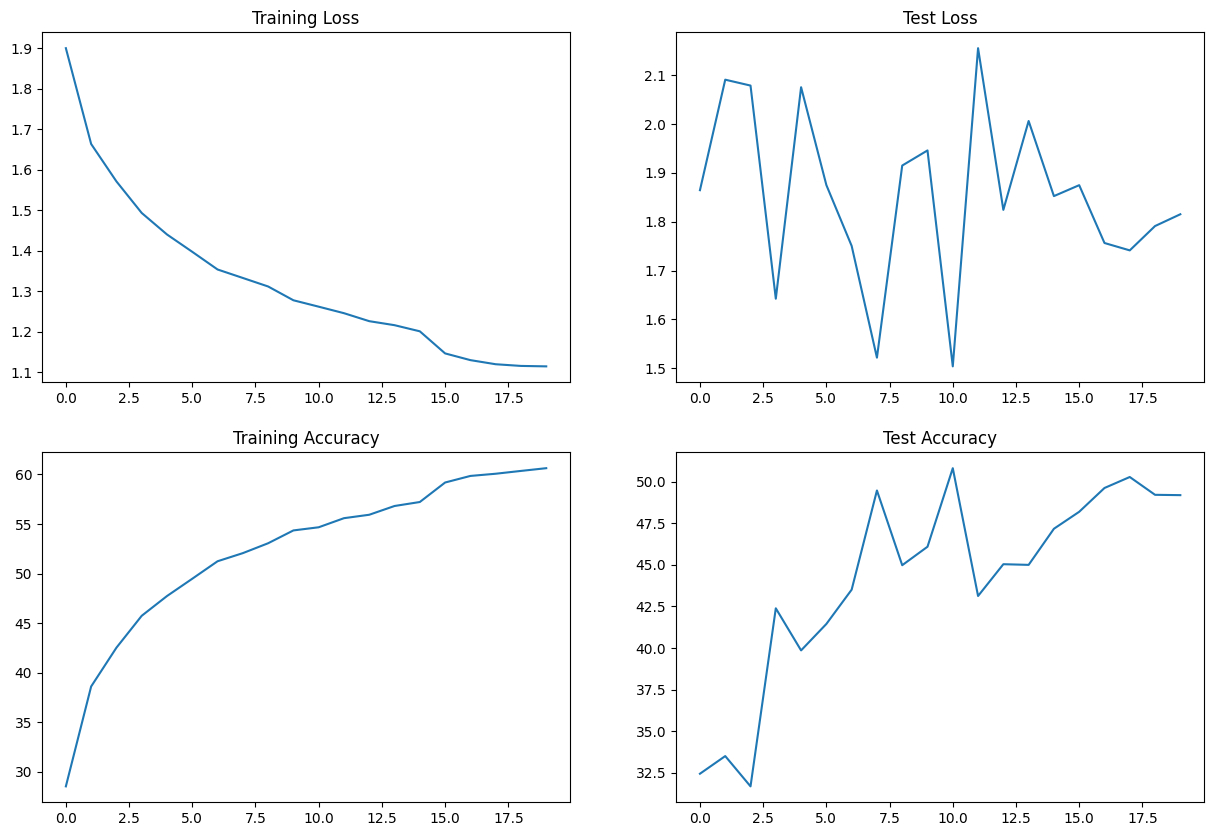

In [12]:
plot_model_training_curves(train_accs, test_accs, train_losses, test_losses)

In [13]:
all_preds, all_labels, incorrect = get_all_and_incorrect_preds(model, train_loader, device='cuda')

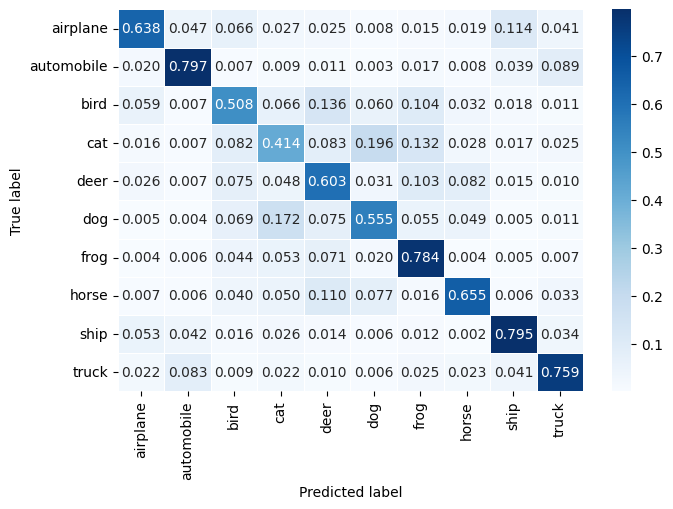

In [14]:
plot_confusion_matrix(all_labels, all_preds, normalize=True,classes=classes)

# LN

In [15]:
modelLN = Net(
                norm_method='ln',
                # channels = [3,16,20,28,40,10],
                grp=1,
                dp_rate=0.1
        ).to(device)

summary(modelLN,(3,32,32),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         Dropout2d-4           [-1, 16, 32, 32]               0
         ConvLayer-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 16, 32, 32]           2,304
         GroupNorm-7           [-1, 16, 32, 32]              32
              ReLU-8           [-1, 16, 32, 32]               0
         Dropout2d-9           [-1, 16, 32, 32]               0
        ConvLayer-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]             256
        MaxPool2d-12           [-1, 16, 16, 16]               0
       TransBlock-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 20,

In [16]:
optimizer = optim.SGD(modelLN.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=5)
# New Line
criterion = F.nll_loss
num_epochs = 20

try:
    del train_losses,test_losses,train_accs,test_accs,train_acc,test_acc
except Exception as e:
    print('')

train_losses = []
test_losses = []
train_accs = []; train_acc=[]
test_accs = []; test_acc=[]


for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(modelLN, device, train_loader, optimizer, criterion)
  test_accs, test_losses = test(modelLN, device, test_loader, criterion)
  scheduler.step(test_losses[-1])


Epoch 1
Train: 100% Loss=1.9945 Batch_id=195 Accuracy=17.64
Test set: Average loss: 1.9989, Accuracy: 2409/10000 (24.09%)

Epoch 2
Train: 100% Loss=1.9708 Batch_id=195 Accuracy=27.91
Test set: Average loss: 1.8791, Accuracy: 2968/10000 (29.68%)

Epoch 3
Train: 100% Loss=1.7723 Batch_id=195 Accuracy=31.50
Test set: Average loss: 1.9492, Accuracy: 2989/10000 (29.89%)

Epoch 4
Train: 100% Loss=1.7573 Batch_id=195 Accuracy=34.94
Test set: Average loss: 1.8914, Accuracy: 3287/10000 (32.87%)

Epoch 5
Train: 100% Loss=1.5969 Batch_id=195 Accuracy=37.79
Test set: Average loss: 1.6835, Accuracy: 3811/10000 (38.11%)

Epoch 6
Train: 100% Loss=1.5992 Batch_id=195 Accuracy=40.11
Test set: Average loss: 1.9416, Accuracy: 3168/10000 (31.68%)

Epoch 7
Train: 100% Loss=1.7160 Batch_id=195 Accuracy=41.80
Test set: Average loss: 1.9306, Accuracy: 3023/10000 (30.23%)

Epoch 8
Train: 100% Loss=1.3611 Batch_id=195 Accuracy=43.38
Test set: Average loss: 1.9105, Accuracy: 3226/10000 (32.26%)

Epoch 9
Train: 

KeyboardInterrupt: 

In [ ]:
plot_model_training_curves(train_accs, test_accs, train_losses, test_losses)

In [ ]:
all_preds, all_labels, incorrect = get_all_and_incorrect_preds(modelLN, train_loader, device='cuda')

In [ ]:
plot_confusion_matrix(all_labels, all_preds, classes=classes)

# GN

In [ ]:
modelGN = Net(
                norm_method='ln',
                # channels = [3,16,20,28,40,10],
                grp=4,
                dp_rate=0.1
        ).to(device)

summary(modelGN,(3,32,32),device=device.type)

In [ ]:
optimizer = optim.SGD(modelGN.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=5)
# New Line
criterion = F.nll_loss
num_epochs = 20

try:
    del train_losses,test_losses,train_accs,test_accs,train_acc,test_acc
except Exception as e:
    print('')


train_losses = []
test_losses = []
train_accs = []; train_acc=[]
test_accs = []; test_acc=[]


for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(modelGN, device, train_loader, optimizer, criterion)
  test_accs, test_losses = test(modelGN, device, test_loader, criterion)
  scheduler.step(test_losses[-1])

In [ ]:
plot_model_training_curves(train_accs, test_accs, train_losses, test_losses)

In [ ]:
all_preds, all_labels, incorrect = get_all_and_incorrect_preds(modelGN, train_loader, device='cuda')

In [ ]:
plot_confusion_matrix(all_labels, all_preds, classes=classes)
